# Imports and Extra Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
from datetime import timedelta
%load_ext line_profiler
sns.set(style="darkgrid")
import requests
import pprint
import re
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
time1 = datetime.now()
filename = 'cleaned_LAX.csv'
df = pd.read_csv(
         filename,
         header=0, 
         parse_dates = ['FL_DATE','dep_datetime','arr_datetime']
)

time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\2pawn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (49,78,85,116,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:00:06.482909


# Binary Classification

Using "DEP_DEL15":
- 1 means delay >= 15
- 0 means delay < 15 (on-time / early)

Goal is to predict this classification.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef, zero_one_loss, balanced_accuracy_score, roc_auc_score
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

C:\Users\2pawn\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Preprocessing

In [23]:
# sort by date for RNN since data was combined from all airports, not chronologically
df = df.sort_values(by=['FL_DATE', 'CRS_DEP_TIME'])
column_list = ['number_of_seats', 'dest_passenger_count', 'OP_CARRIER_AIRLINE_ID',
                 'DISTANCE', 'DEP_TIME', 'temp_origin_imp', 'precip_origin_imp', 'mfr_name', 'DEP_DEL15']

# change categorical to encoded
categorical_columns = ['mfr_name']
data = pd.get_dummies(df[column_list], columns=categorical_columns)

# standardize
scaler = preprocessing.MinMaxScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

C:\Users\2pawn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [24]:
data.head(10)

,number_of_seats,dest_passenger_count,OP_CARRIER_AIRLINE_ID,DISTANCE,DEP_TIME,temp_origin_imp,precip_origin_imp,DEP_DEL15,mfr_name_AIRBUS,mfr_name_BOEING,mfr_name_BOMBARDIER INC,mfr_name_EMBRAER,mfr_name_MCDONNELL DOUGLAS
411646,0.401840,0.632948,0.231721,0.453682,0.007920,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
233380,0.401840,0.411787,0.231721,0.891924,0.010004,0.401926,0.0,0.0,1.0,0.0,0.0,0.0,0.0
414293,0.420245,0.283604,0.231721,0.915677,0.010838,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
414297,0.564417,0.366003,0.223285,0.572447,0.010838,0.177419,0.0,0.0,0.0,1.0,0.0,0.0,0.0
414296,0.239264,0.136893,0.231721,0.676168,0.019175,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
414291,0.398773,0.767864,0.586614,0.655186,0.021676,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
109206,0.420245,0.437711,0.231721,0.806017,0.021676,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
414292,0.374233,0.767864,0.231721,0.655186,0.021259,0.177419,0.0,0.0,0.0,1.0,0.0,0.0,0.0
414294,0.401840,0.632948,0.231721,0.453682,0.022093,0.177419,0.0,0.0,1.0,0.0,0.0,0.0,0.0
414295,0.500000,0.389776,0.328459,0.510689,0.022509,0.177419,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [26]:
data.iloc[:,[7]].head(10)

,DEP_DEL15
411646,0.0
233380,0.0
414293,0.0
414297,0.0
414296,0.0
414291,0.0
109206,0.0
414292,0.0
414294,0.0
414295,0.0


In [27]:
look_back = 5 # Number of flights to look back for RNN

def create_dataset(dataset, look_back):
    # Converts dataset to sequences
    dataX = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
    return np.array(dataX)

a = create_dataset(data.values, look_back)

X_train, X_test, y_train, y_test = train_test_split(np.delete(a, [7], axis=2), a[:,:,7], test_size=0.2, random_state=123)
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (338717, 5, 12)
X_test.shape:  (84680, 5, 12)
y_train.shape:  (338717, 5)
y_test.shape:  (84680, 5)


## Dense Layers

In [51]:
model = Sequential()
model.add(layers.Flatten(input_shape=(5, X_train.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1952      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 165       
Total params: 3,173
Trainable params: 3,173
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Train on 338717 samples, validate on 84680 samples
Epoch 1/20
338717/338717 [==============================] - 10s 29us/step - loss: 0.5429 - acc: 0.7682 - val_loss: 0.5410 - val_acc: 0.7673
Epoch 2/20
338717/338717 [==============================] - 9s 26us/step - loss: 0.5398 - acc: 0.7683 - val_loss: 0.5380 - val_acc: 0.7673
Epoch 3/20
338717/338717 [==============================] - 9s 25us/step - loss: 0.5300 - acc: 0.7694 - val_loss: 0.5094 - val_acc: 0.7676
Epoch 4/20
338717/338717 [==============================] - 8s 25us/step - loss: 0.5109 - acc: 0.7726 - val_loss: 0.4834 - val_acc: 0.7736
Epoch 5/20
338717/338717 [==============================] - 9s 26us/step - loss: 0.4913 - acc: 0.7840 - val_loss: 0.4416 - val_acc: 0.8023
Epoch 6/20
338717/338717 [==============================] - 9s 26us/step - loss: 0.4653 - acc: 0.8011 - val_loss: 0.4262 - val_acc: 0.8171
Epoch 7/20
338717/338717 [==============================] - 9s 26us/step - loss: 0.4576 - acc: 0.8041 - val_loss: 

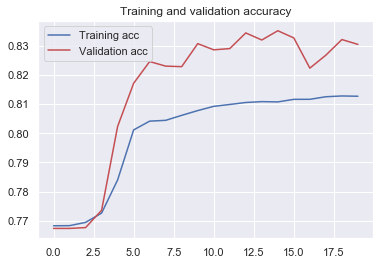

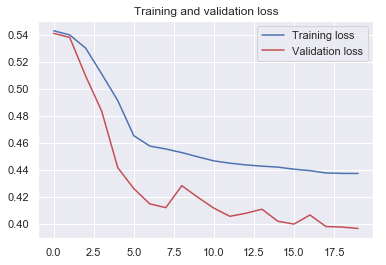

In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# RNN

In [34]:
model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(5, X_train.shape[-1])))
model.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.2))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 5, 32)             4320      
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 23,269
Trainable params: 23,269
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 338717 samples, validate on 84680 samples
Epoch 1/10
338717/338717 [==============================] - 57s 169us/step - loss: 0.5094 - acc: 0.7849 - val_loss: 0.4067 - val_acc: 0.8404
Epoch 2/10
338717/338717 [==============================] - 56s 165us/step - loss: 0.4236 - acc: 0.8266 - val_loss: 0.3842 - val_acc: 0.8445
Epoch 3/10
338717/338717 [==============================] - 54s 160us/step - loss: 0.4100 - acc: 0.8288 - val_loss: 0.3749 - val_acc: 0.8483
Epoch 4/10
338717/338717 [==============================] - 54s 161us/step - loss: 0.4049 - acc: 0.8293 - val_loss: 0.3738 - val_acc: 0.8440
Epoch 5/10
338717/338717 [==============================] - 54s 158us/step - loss: 0.4017 - acc: 0.8294 - val_loss: 0.3691 - val_acc: 0.8447
Epoch 6/10
338717/338717 [==============================] - 53s 157us/step - loss: 0.3993 - acc: 0.8296 - val_loss: 0.3665 - val_acc: 0.8464
Epoch 7/10
338717/338717 [==============================] - 53s 158us/step - loss: 0.3973 - acc: 0.8294

## Results

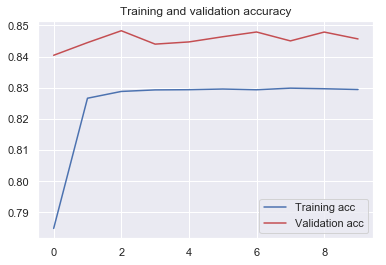

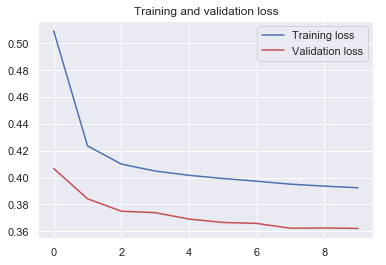

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Saving Model

In [37]:
# model.save_weights("RNN.h5")
import tensorflow as tf
tf.keras.models.save_model(model,"./LAX_RNN_1.h5", overwrite=True, include_optimizer=True)

## Tweaking Architecture

Making first GRU layer have 64 neurons

In [38]:
model2 = Sequential()
model2.add(layers.GRU(64, 
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(5, X_train.shape[-1])))
model2.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.2))
model2.add(layers.Dense(5, activation='softmax'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 5, 64)             14784     
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 39,877
Trainable params: 39,877
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 338717 samples, validate on 84680 samples
Epoch 1/10
338717/338717 [==============================] - 58s 172us/step - loss: 0.5030 - acc: 0.7885 - val_loss: 0.4087 - val_acc: 0.8369
Epoch 2/10
338717/338717 [==============================] - 56s 166us/step - loss: 0.4213 - acc: 0.8272 - val_loss: 0.3800 - val_acc: 0.8443
Epoch 3/10
338717/338717 [==============================] - 58s 171us/step - loss: 0.4070 - acc: 0.8292 - val_loss: 0.3707 - val_acc: 0.8428
Epoch 4/10
338717/338717 [==============================] - 58s 171us/step - loss: 0.3997 - acc: 0.8288 - val_loss: 0.3650 - val_acc: 0.8439
Epoch 5/10
338717/338717 [==============================] - 56s 167us/step - loss: 0.3948 - acc: 0.8291 - val_loss: 0.3635 - val_acc: 0.8486
Epoch 6/10
338717/338717 [==============================] - 56s 167us/step - loss: 0.3914 - acc: 0.8292 - val_loss: 0.3586 - val_acc: 0.8444
Epoch 7/10
338717/338717 [==============================] - 56s 167us/step - loss: 0.3889 - acc: 0.8290

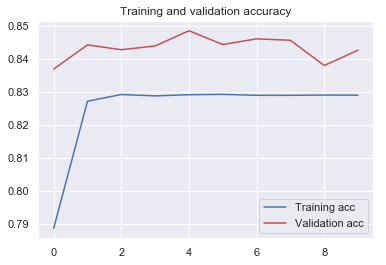

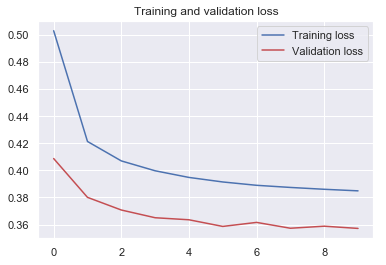

In [40]:
tf.keras.models.save_model(model2,"./LAX_RNN_2.h5", overwrite=True, include_optimizer=True)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Making both dropouts = 0.2

In [41]:
model3 = Sequential()
model3.add(layers.GRU(64, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(5, X_train.shape[-1])))
model3.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.2))
model3.add(layers.Dense(5, activation='softmax'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 5, 64)             14784     
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                24768     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 39,877
Trainable params: 39,877
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 338717 samples, validate on 84680 samples
Epoch 1/10
338717/338717 [==============================] - 58s 172us/step - loss: 0.5213 - acc: 0.7792 - val_loss: 0.4218 - val_acc: 0.8357
Epoch 2/10
338717/338717 [==============================] - 56s 166us/step - loss: 0.4411 - acc: 0.8187 - val_loss: 0.3888 - val_acc: 0.8447
Epoch 3/10
338717/338717 [==============================] - 56s 166us/step - loss: 0.4256 - acc: 0.8206 - val_loss: 0.3858 - val_acc: 0.8441
Epoch 4/10
338717/338717 [==============================] - 57s 169us/step - loss: 0.4188 - acc: 0.8211 - val_loss: 0.3813 - val_acc: 0.8455
Epoch 5/10
338717/338717 [==============================] - 56s 166us/step - loss: 0.4147 - acc: 0.8213 - val_loss: 0.3751 - val_acc: 0.8443
Epoch 6/10
338717/338717 [==============================] - 56s 166us/step - loss: 0.4120 - acc: 0.8213 - val_loss: 0.3740 - val_acc: 0.8482
Epoch 7/10
338717/338717 [==============================] - 56s 165us/step - loss: 0.4096 - acc: 0.8213

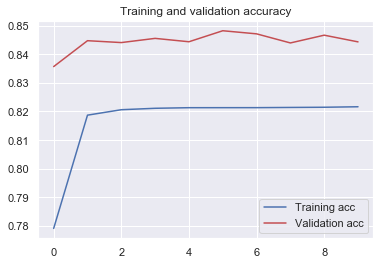

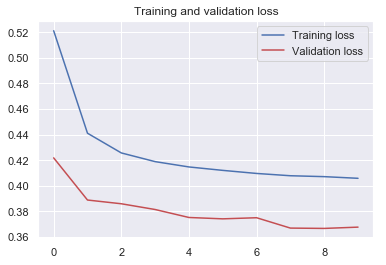

In [43]:
tf.keras.models.save_model(model3,"./LAX_RNN_3.h5", overwrite=True, include_optimizer=True)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Making ``recurrent_initializer`` = 'he_normal'

In [44]:
model4 = Sequential()
model4.add(layers.GRU(64, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     recurrent_initializer='he_normal',
                     return_sequences=True,
                     input_shape=(5, X_train.shape[-1])))
model4.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     recurrent_initializer='he_normal',))
model4.add(layers.Dense(5, activation='softmax'))

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model4.summary()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 5, 64)             14784     
_________________________________________________________________
gru_13 (GRU)                 (None, 64)                24768     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 325       
Total params: 39,877
Trainable params: 39,877
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 338717 samples, validate on 84680 samples
Epoch 1/10
338717/338717 [==============================] - 57s 169us/step - loss: 0.5233 - acc: 0.7777 - val_loss: 0.4328 - val_acc: 0.8279
Epoch 2/10
338717/338717 [==============================] - 56s 164us/step - loss: 0.4444 - acc: 0.8181 - val_loss: 0.3953 - val_acc: 0.8454
Epoch 3/10
338717/338717 [==============================] - 55s 163us/step - loss: 0.4280 - acc: 0.8205 - val_loss: 0.3821 - val_acc: 0.8431
Epoch 4/10
338717/338717 [==============================] - 56s 164us/step - loss: 0.4194 - acc: 0.8210 - val_loss: 0.3768 - val_acc: 0.8489
Epoch 5/10
338717/338717 [==============================] - 56s 165us/step - loss: 0.4147 - acc: 0.8211 - val_loss: 0.3758 - val_acc: 0.8460
Epoch 6/10
338717/338717 [==============================] - 55s 164us/step - loss: 0.4113 - acc: 0.8212 - val_loss: 0.3695 - val_acc: 0.8485
Epoch 7/10
338717/338717 [==============================] - 55s 162us/step - loss: 0.4094 - acc: 0.8209

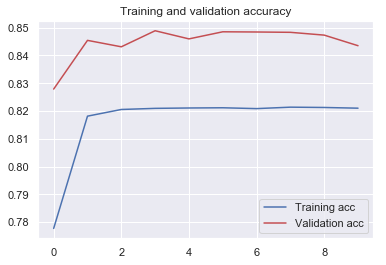

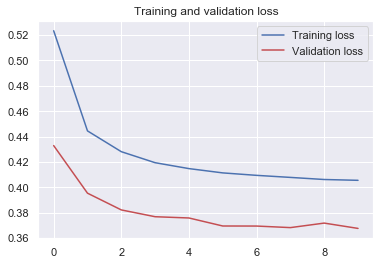

In [46]:
tf.keras.models.save_model(model4,"./LAX_RNN_4.h5", overwrite=True, include_optimizer=True)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
model5 = Sequential()
model5.add(layers.LSTM(64, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     recurrent_initializer='he_normal',
                     return_sequences=True,
                     input_shape=(5, X_train.shape[-1])))
model5.add(layers.LSTM(64, 
                     activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     recurrent_initializer='he_normal',))
model5.add(layers.Dense(5, activation='softmax'))

model5.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             19712     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325       
Total params: 53,061
Trainable params: 53,061
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 338717 samples, validate on 84680 samples
Epoch 1/10
338717/338717 [==============================] - 73s 217us/step - loss: 0.5420 - acc: 0.7683 - val_loss: 0.5368 - val_acc: 0.7673
Epoch 2/10
338717/338717 [==============================] - 69s 204us/step - loss: 0.4649 - acc: 0.8072 - val_loss: 0.4038 - val_acc: 0.8434
Epoch 3/10
338717/338717 [==============================] - 76s 224us/step - loss: 0.4325 - acc: 0.8211 - val_loss: 0.3881 - val_acc: 0.8441
Epoch 4/10
338717/338717 [==============================] - 74s 218us/step - loss: 0.4220 - acc: 0.8216 - val_loss: 0.3792 - val_acc: 0.8454
Epoch 5/10
338717/338717 [==============================] - 76s 224us/step - loss: 0.4161 - acc: 0.8217 - val_loss: 0.3760 - val_acc: 0.8464
Epoch 6/10
338717/338717 [==============================] - 73s 216us/step - loss: 0.4128 - acc: 0.8215 - val_loss: 0.3742 - val_acc: 0.8444
Epoch 7/10
338717/338717 [==============================] - 71s 209us/step - loss: 0.4095 - acc: 0.8217

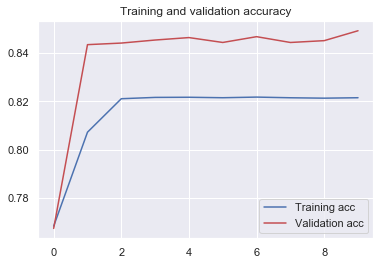

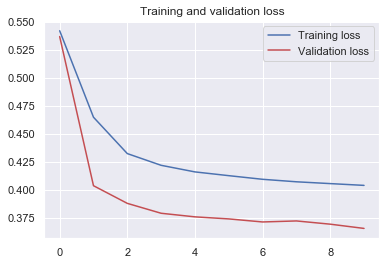

In [62]:
tf.keras.models.save_model(model5,"./LAX_RNN_5.h5", overwrite=True, include_optimizer=True)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Assessing Performance

In [83]:
1 - data['DEP_DEL15'].mean()

0.7680673023100922

So, the baseline model would just to be assign 0 to all flights. This gives an accuracy of 76.8%, meaning our validation accuracy of 84.5% is a significant improvement.

In [100]:
data.loc[:, data.columns != 'DEP_DEL15'].head()

,number_of_seats,origin_passenger_count,dest_passenger_count,OP_CARRIER_AIRLINE_ID,DISTANCE,DEP_TIME,temp_origin_imp,precip_origin_imp,mfr_name_AIRBUS,mfr_name_BOEING,mfr_name_BOMBARDIER INC,mfr_name_EMBRAER,mfr_name_MCDONNELL DOUGLAS
10685817,0.401840,0.0,0.632948,0.231721,0.453682,0.007920,0.177419,0.0,1.0,0.0,0.0,0.0,0.0
10773718,0.420245,0.0,0.283604,0.231721,0.915677,0.010838,0.177419,0.0,1.0,0.0,0.0,0.0,0.0
6962597,0.401840,0.0,0.411787,0.231721,0.891924,0.010004,0.401926,0.0,1.0,0.0,0.0,0.0,0.0
10773724,0.564417,0.0,0.366003,0.223285,0.572447,0.010838,0.177419,0.0,0.0,1.0,0.0,0.0,0.0
10773723,0.239264,0.0,0.136893,0.231721,0.676168,0.019175,0.177419,0.0,1.0,0.0,0.0,0.0,0.0


## Changing Parameters
Main thing to change first is ``look_back`` value. Let's double it from 5 to 10. Let's stop at 10 epochs this time too.

In [103]:
look_back = 10 # Number of flights to look back for RNN

def create_dataset(dataset, look_back):
    # Converts dataset to sequences
    dataX = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
    return np.array(dataX)

a = create_dataset(data.values, look_back)

X_train, X_test, y_train, y_test = train_test_split(np.delete(a, [8], axis=2), a[:,:,8], test_size=0.2, random_state=123)
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (338713, 10, 13)
X_test.shape:  (84679, 10, 13)
y_train.shape:  (338713, 10)
y_test.shape:  (84679, 10)


In [106]:
model2 = Sequential()
model2.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(look_back, X_train.shape[-1])))
model2.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.2))
model2.add(layers.Dense(look_back, activation='softmax'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 10, 32)            4416      
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 23,690
Trainable params: 23,690
Non-trainable params: 0
_________________________________________________________________


In [107]:
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 338713 samples, validate on 84679 samples
Epoch 1/10
338713/338713 [==============================] - 94s 279us/step - loss: 0.6103 - acc: 0.7685 - val_loss: 0.5379 - val_acc: 0.7783
Epoch 2/10
338713/338713 [==============================] - 94s 277us/step - loss: 0.5051 - acc: 0.7787 - val_loss: 0.4454 - val_acc: 0.7907
Epoch 3/10
338713/338713 [==============================] - 93s 275us/step - loss: 0.4753 - acc: 0.7826 - val_loss: 0.4434 - val_acc: 0.7887
Epoch 4/10
338713/338713 [==============================] - 93s 276us/step - loss: 0.4660 - acc: 0.7835 - val_loss: 0.4330 - val_acc: 0.7896
Epoch 5/10
338713/338713 [==============================] - 93s 274us/step - loss: 0.4599 - acc: 0.7840 - val_loss: 0.4351 - val_acc: 0.7938
Epoch 6/10
338713/338713 [==============================] - 95s 279us/step - loss: 0.4562 - acc: 0.7843 - val_loss: 0.4309 - val_acc: 0.7904
Epoch 7/10
338713/338713 [==============================] - 94s 276us/step - loss: 0.4531 - acc: 0.7847

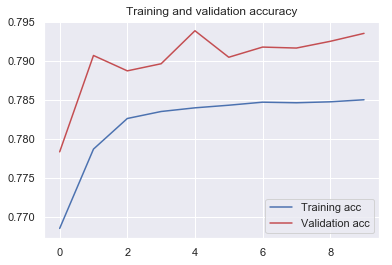

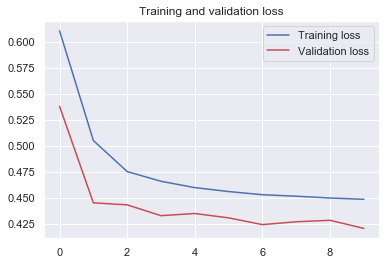

In [108]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [109]:
tf.keras.models.save_model(model,"./LAX_RNN_10lb.h5", overwrite=True, include_optimizer=True)

# Comparison - Random Forest (Old Model)

In [59]:
%%timeit -n 1 -r 1
clf = RandomForestClassifier(n_estimators=50, max_depth=50, 
                             random_state=123)
XRF_train, XRF_test, yRF_train, yRF_test = train_test_split(data.loc[:, data.columns != 'DEP_DEL15'], 
                                                            data['DEP_DEL15'], 
                                                            test_size=0.2, random_state=123)
clf.fit(XRF_train, yRF_train)
print("feature importances: ", clf.feature_importances_)
yRF_pred = clf.predict(XRF_test)
# print(classification_report(yRF_test, yRF_pred))
print(confusion_matrix(yRF_test, yRF_pred))
print("accuracy score: ", accuracy_score(yRF_test, yRF_pred))
# print("matthews corr coef: ", matthews_corrcoef(yRF_test, yRF_pred))
# print("zero one loss: ", zero_one_loss(yRF_test, yRF_pred))
# print("balanced accuracy: ", balanced_accuracy_score(yRF_test, yRF_pred))
print("roc auc score: ", roc_auc_score(yRF_test, yRF_pred))

feature importances:  [3.65576273e-02 4.51570340e-02 2.38412126e-02 5.00804033e-02
 6.68416631e-01 1.47657435e-01 2.25092293e-02 1.87440109e-03
 2.23994276e-03 8.46681006e-04 8.11343508e-04 8.05867959e-06]
[[60828  4086]
 [ 7377 12390]]
accuracy score:  0.8646331526552592
roc auc score:  0.7819287134342374
19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
